# Kaggle Playground Series – Season 5, Episode 10  
### Road Accident Risk 

This notebook explores the **Kaggle Playground Series – Season 5, Episode 10** competition, which aims to **predict the likelihood of accidents across different types of roads**.

The workflow includes a **LightGBM baseline setup** with **cross-validation** for model evaluation.  
Data preprocessing is kept **minimal**, focusing on establishing a **simple yet effective starting point** with a **basic set of model parameters**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

# EDA

In [4]:
data.shape

(517754, 14)

In [5]:
data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [6]:
data.tail()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51
517753,517753,highway,2,0.31,45,dim,rainy,False,True,afternoon,True,True,2,0.22


In [7]:
data.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [9]:
missing_table = pd.DataFrame({
    'Missing Values': data.isna().sum(),
    'Percentage (%)': (data.isnull().mean() * 100).round(2)
})

print(missing_table.sort_values(by='Missing Values', ascending=False))

                        Missing Values  Percentage (%)
id                                   0             0.0
road_type                            0             0.0
num_lanes                            0             0.0
curvature                            0             0.0
speed_limit                          0             0.0
lighting                             0             0.0
weather                              0             0.0
road_signs_present                   0             0.0
public_road                          0             0.0
time_of_day                          0             0.0
holiday                              0             0.0
school_season                        0             0.0
num_reported_accidents               0             0.0
accident_risk                        0             0.0


In [10]:
data.nunique()

id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64

# Data visualisation

Target variable distribution

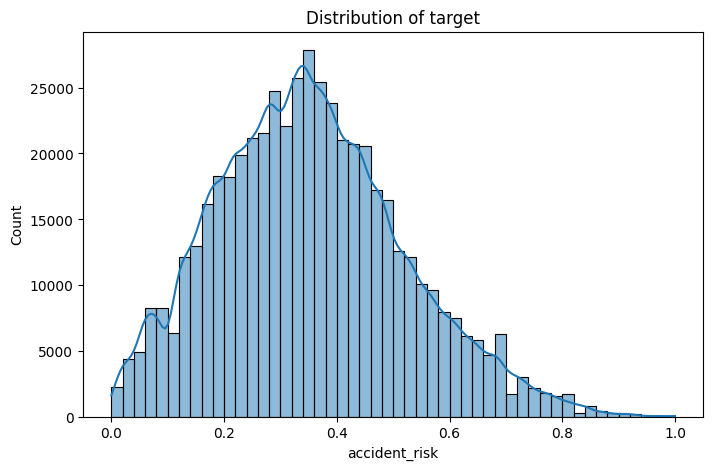

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(data['accident_risk'], kde=True, bins=50)
plt.title(f"Distribution of target")
plt.show()

Visualisation of numerical variables

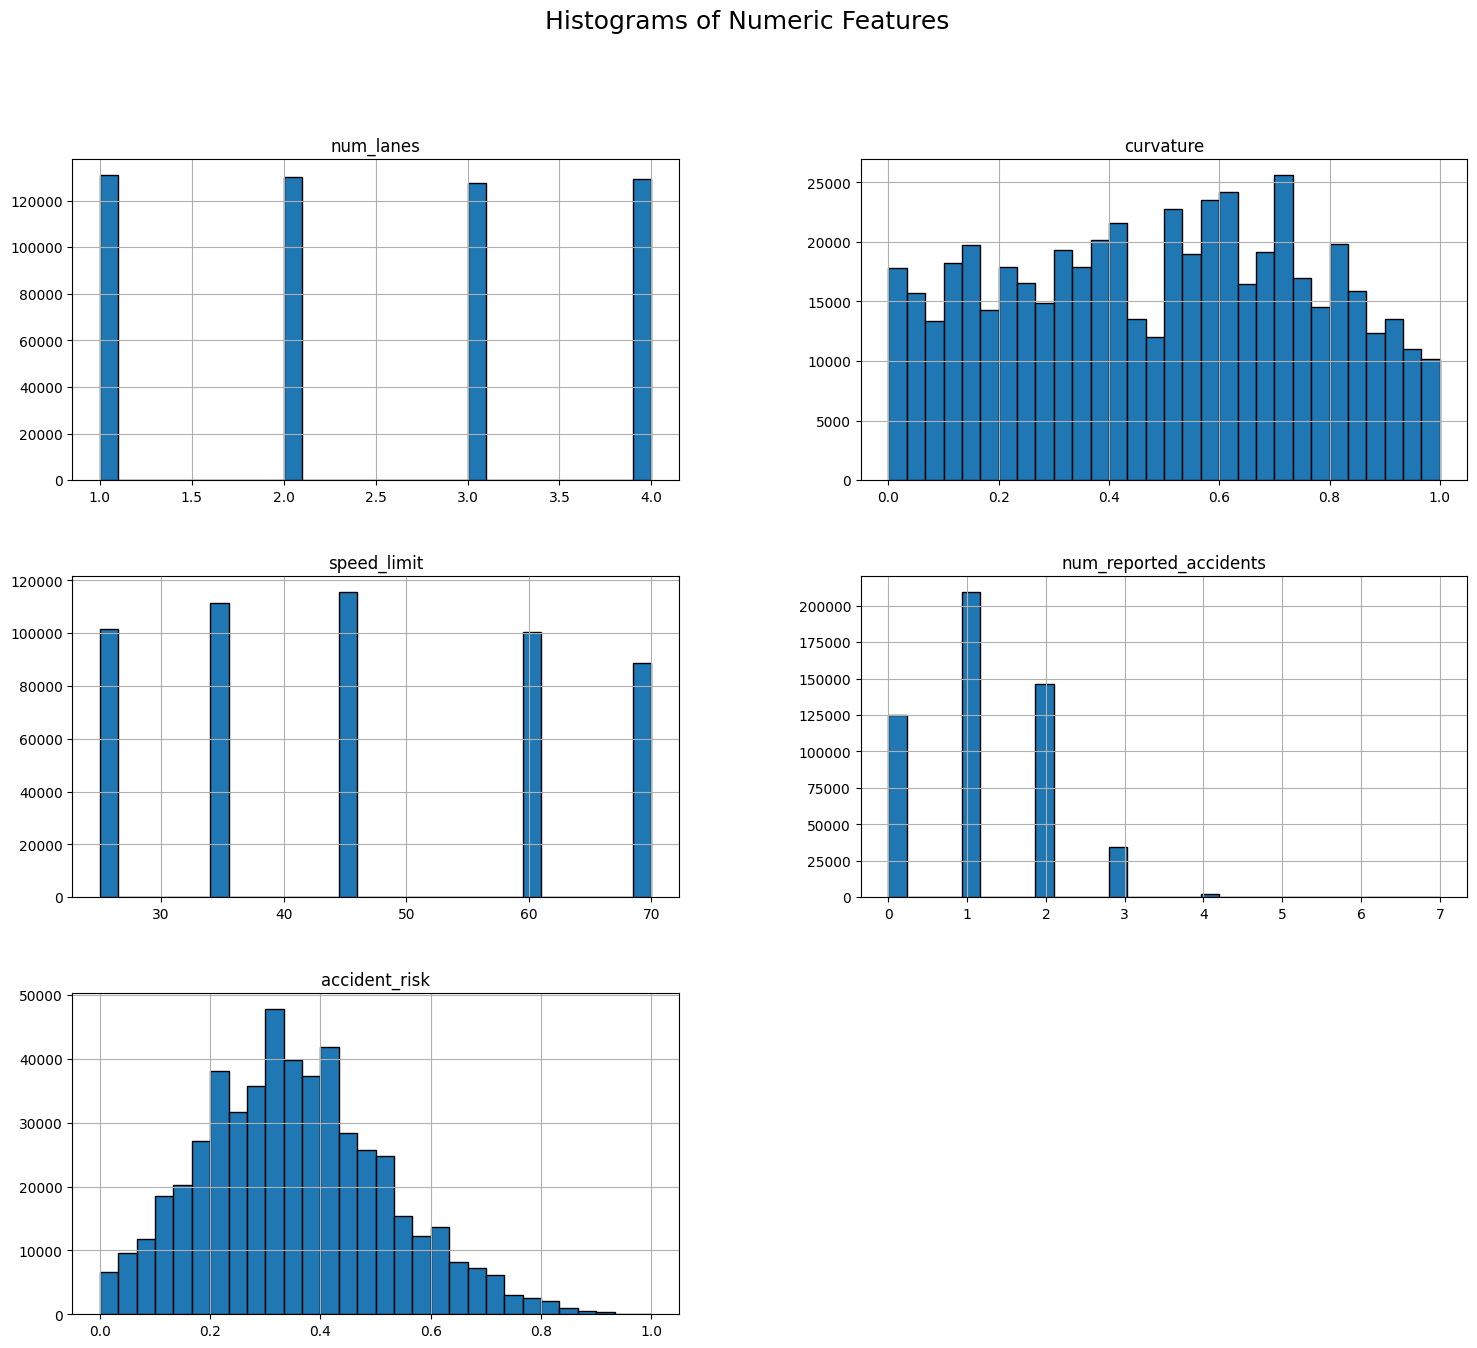

In [12]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('id')

data[numeric_cols].hist(bins=30, figsize=(18, 15), edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=18)
plt.show()

Visualisation of categorical variables

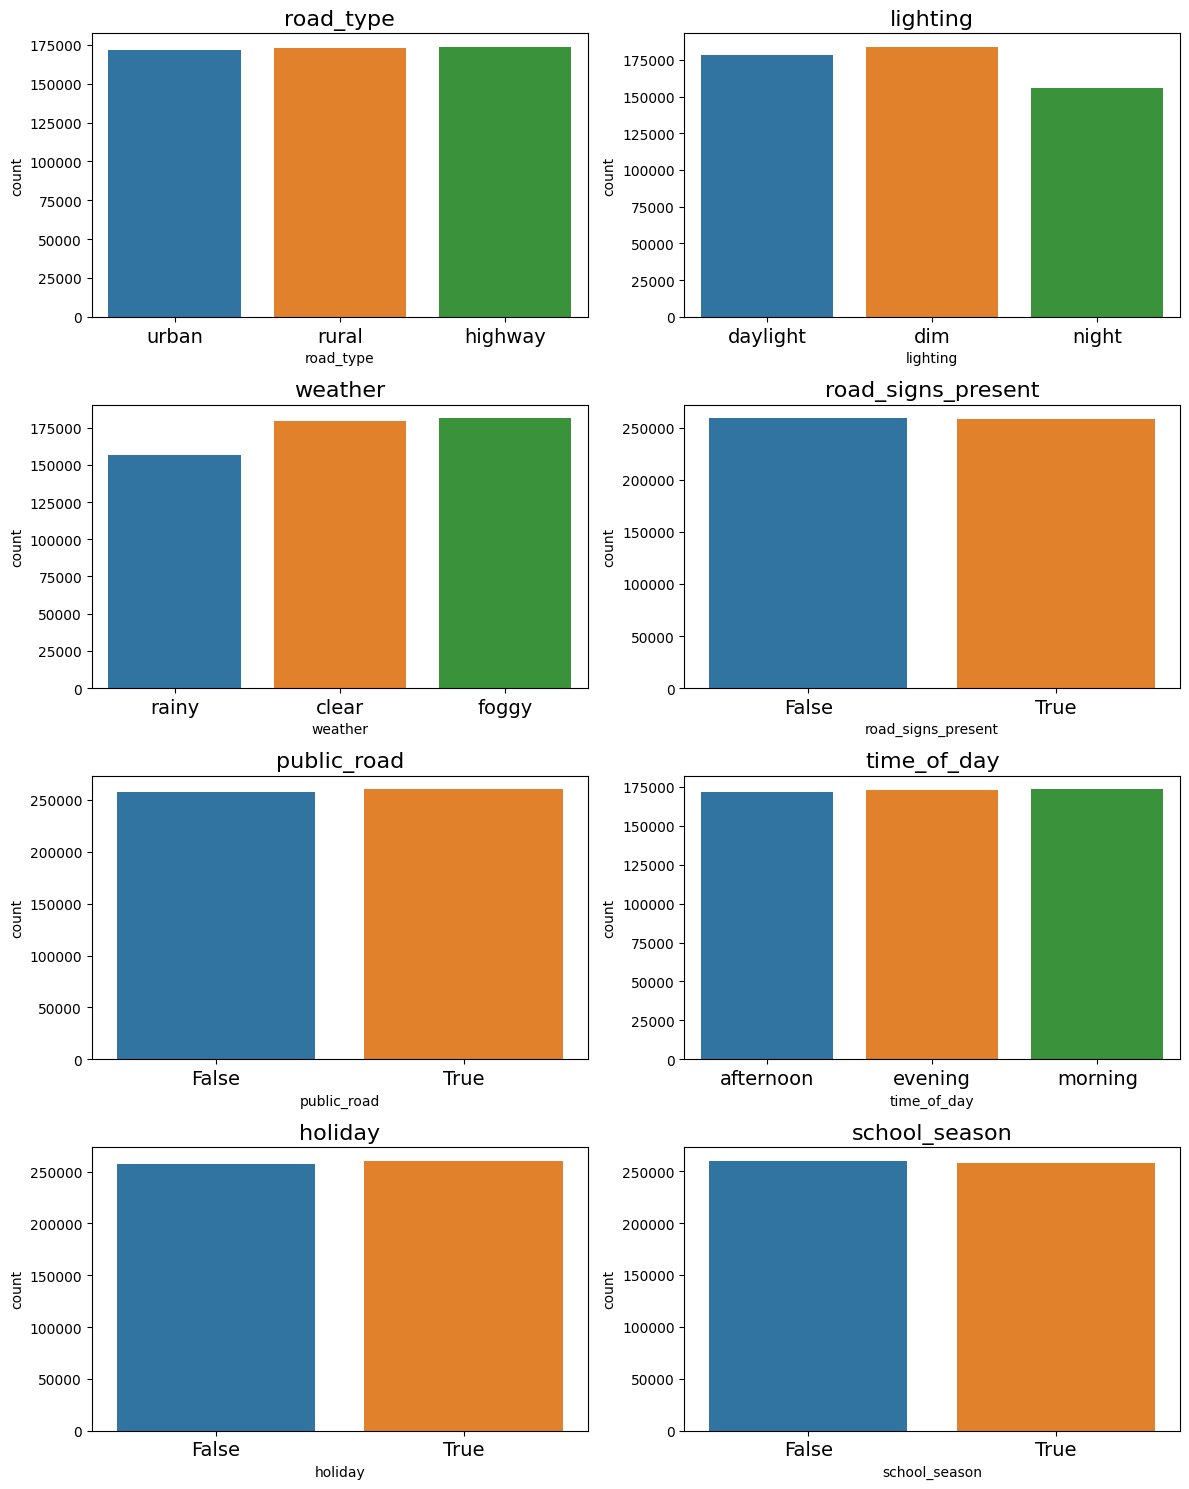

In [13]:
cat_cols = data.select_dtypes(include=['bool', 'object']).columns.tolist()

fig, axes = plt.subplots(4, 2, figsize=(12, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(col, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize = 14)


plt.tight_layout()
plt.show()

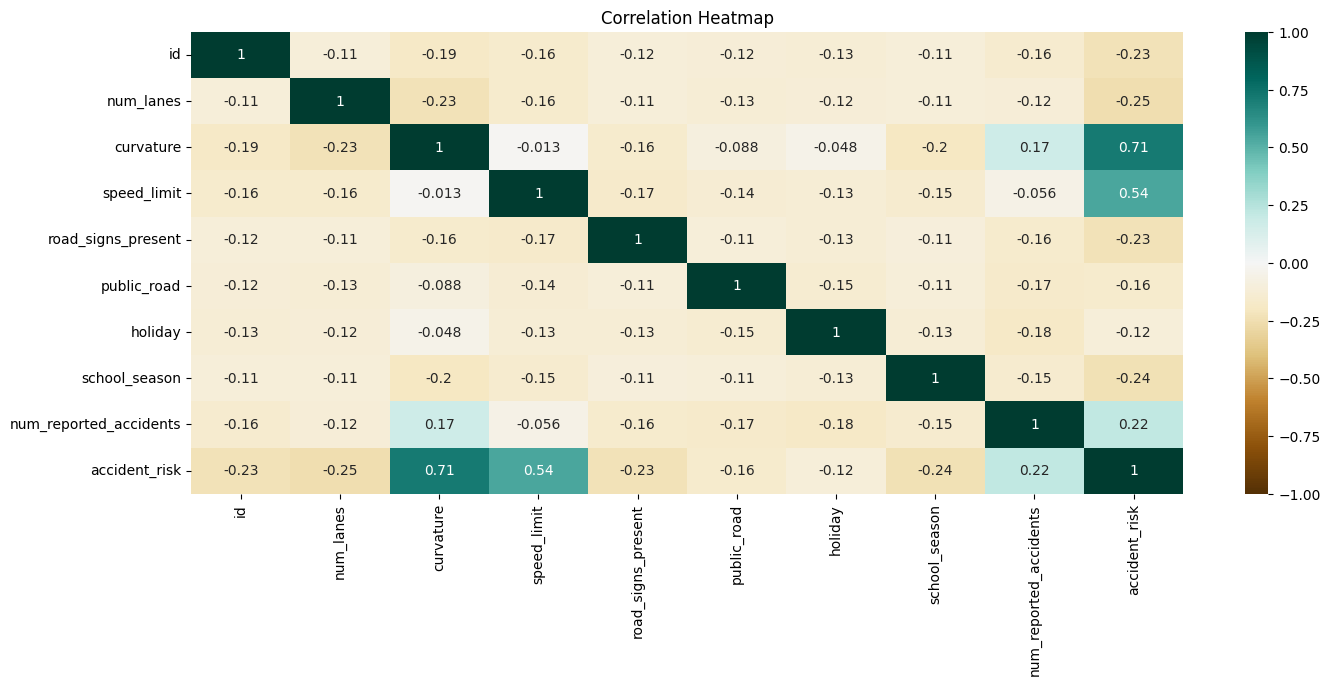

In [14]:
plt.figure(figsize=(16, 6))

data_corr = data.corr(numeric_only=True)

heatmap = sns.heatmap(data_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})

plt.show()

Top 5 correlated features with target

In [15]:
correlations = data[numeric_cols].corr()['accident_risk']
correlations = correlations.drop('accident_risk')

top_features = correlations.abs().sort_values(ascending=False).head(5).index.tolist()

print("Top 5 features correlated with target:")
print(correlations[top_features])

Top 5 features correlated with target:
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
num_lanes                -0.006003
Name: accident_risk, dtype: float64


Boxplots for numerical features

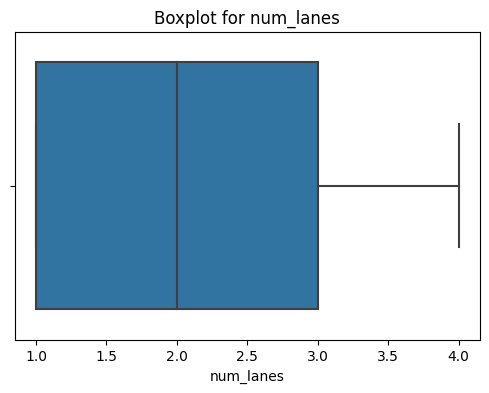

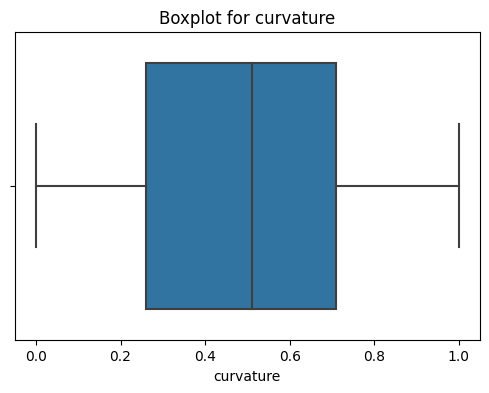

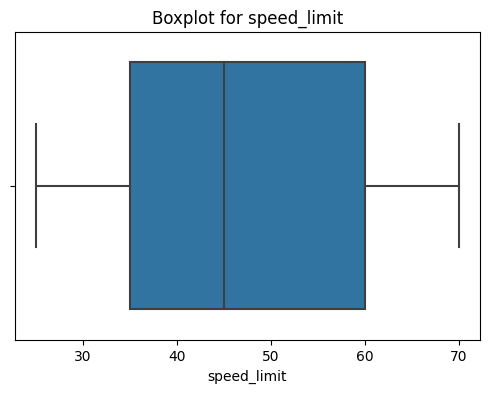

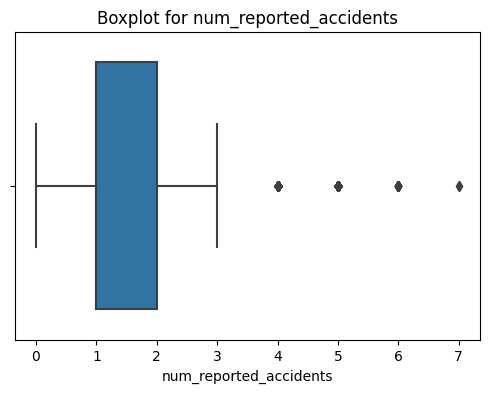

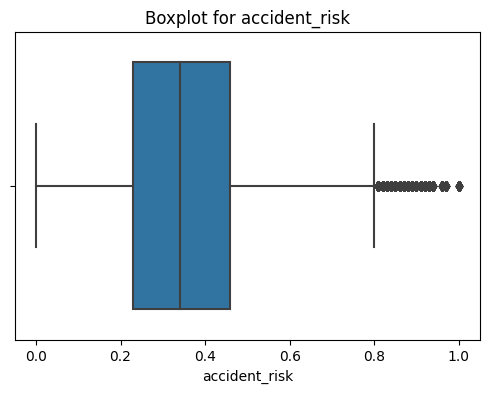

In [16]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# Data preprocessing

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Feature engineering

In [18]:
def add_engineered_features(df):
    data = df.copy()

    # 1. Combined categorical features
    data["road_weather"] = data["road_type"].astype(str) + "_" + data["weather"].astype(str)
    data["road_lighting"] = data["road_type"].astype(str) + "_" + data["lighting"].astype(str)
    data["time_weather"] = data["time_of_day"].astype(str) + "_" + data["weather"].astype(str)

    # 2. Numerical interaction features
    data["speed_curvature_ratio"] = data["speed_limit"] / (data["curvature"] + 0.001)
    data["accidents_per_lane"] = data["num_reported_accidents"] / (data["num_lanes"] + 0.001)
    data["traffic_intensity"] = data["num_lanes"] * data["speed_limit"]

    # 3. Environmental risk conditions
    data["is_high_risk_condition"] = (
        ((data["weather"].isin(["Rain", "Snow", "Fog"])) &
         (data["lighting"].isin(["Low", "Dark"]))) |
        ((data["time_of_day"].isin(["Night", "Late Evening"])) &
         (data["weather"].isin(["Rain", "Fog"])))
    ).astype(int)

    # 4. Composite road stress index
    data["road_stress_index"] = (
        0.4 * data["curvature"] +
        0.3 * (data["speed_limit"] / 70) + 
        0.3 * (data["num_reported_accidents"] / data["num_reported_accidents"].max())
    )

    return data

In [19]:
X = data.drop(['accident_risk'], axis=1)
y = data['accident_risk']

In [20]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", Pipeline([
        #     ("scaler", StandardScaler())
        # ]), numerical_cols),

        ("cat", Pipeline([
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
    ]
)

In [22]:
# X_processed = preprocessor.fit_transform(X)
# X_test_processed = preprocessor.transform(test_data)

In [23]:
X_processed = add_engineered_features(X)
X_test_processed = add_engineered_features(test_data)

# Model building

In [24]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [25]:
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "device": "gpu" if os.environ.get("CUDA_VISIBLE_DEVICES") else "cpu",
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "num_leaves": 50,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "min_child_samples": 20,
    "verbose": -1,
    "random_state": 42
}

In [26]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [27]:
categorical_cols = X_processed.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
for col in categorical_cols:
    X_processed[col] = X_processed[col].astype('category')
    X_test_processed[col] = X_test_processed[col].astype('category')

In [28]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

oof_preds_lgb = np.zeros(len(X_processed))
test_preds_lgb = np.zeros(len(X_test_processed))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_processed, y)):
    print(f"Training fold {fold+1}...")
    X_train, X_valid = X_processed.iloc[train_idx], X_processed.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # ---------------- LightGBM ----------------
    lgb_model  = lgb.LGBMRegressor(categorical_feature=categorical_cols, **lgb_params)
    lgb_model .fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="rmse",
        callbacks=[
        lgb.early_stopping(stopping_rounds=300)]
        )

    oof_preds_lgb[valid_idx] = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration_)
    test_preds_lgb += lgb_model.predict(X_test_processed, num_iteration=lgb_model.best_iteration_) / kf.n_splits

rmse_lgb = rmse(y, oof_preds_lgb)
print(f"LightGBM OOF RMSE: {rmse_lgb:.5f}")

Training fold 1...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3919]	valid_0's rmse: 0.0560601
Training fold 2...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2315]	valid_0's rmse: 0.0565359
Training fold 3...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2620]	valid_0's rmse: 0.0563269
Training fold 4...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2654]	valid_0's rmse: 0.0560208
Training fold 5...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1965]	valid_0's rmse: 0.0563473
Training fold 6...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2078]	valid_0's rmse: 0.0560816
Training fold 7...
Training until validation scores don't improve for 300 rounds
Early stopping, best iter

# Submition

In [29]:
submission = pd.DataFrame({
    'id': test_data["id"],
    'y': test_preds_lgb
})

In [30]:
submission

,id,y
0,517754,0.297071
1,517755,0.124559
2,517756,0.183813
3,517757,0.317418
4,517758,0.406804
...,...,...
172580,690334,0.112578
172581,690335,0.519884
172582,690336,0.255869
172583,690337,0.124133


In [31]:
submission.to_csv('submission.csv', index=False)